In [51]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from tqdm import tqdm
import wandb
from PIL import Image

In [2]:
# Initialize Weights & Biases (wandb)
wandb.init(project="agco-anomaly-classification", entity="sameerhashmi1995")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995. Use `wandb login --relogin` to force relogin


In [93]:
class CustomSegmentationDataset(Dataset):
    """
    Custom dataset class for loading good images and synthetic anomaly images along with their masks.
    It reads images from good and synthetic folders and assigns labels accordingly. For synthetic images, it also loads the corresponding masks.
    """
    def __init__(self, good_image_dir, synthetic_image_dir, transform=None):
        self.good_image_dir = good_image_dir
        self.synthetic_image_dir = synthetic_image_dir
        self.transform = transform
        self.data = []

        # Load good images
        for img_file in os.listdir(good_image_dir):
            img_path = os.path.join(good_image_dir, img_file)
            if os.path.isfile(img_path):
                self.data.append((img_path, None, 0))  # Label 0 for good images, no mask

        # Load synthetic images and their masks
        for img_file in os.listdir(synthetic_image_dir):
            if '_anommaly' in img_file:
                img_path = os.path.join(synthetic_image_dir, img_file)
                mask_file = img_file.replace('_anommaly', '_mask')
                mask_path = os.path.join(synthetic_image_dir, mask_file)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    self.data.append((img_path, mask_path, 1))  # Label 1 for synthetic anomaly images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L') if mask_path else None
        
        if self.transform:
            image = self.transform(image)
            if mask:
                mask = transforms.Resize((256, 256))(mask)  # Resize the mask to match the output size
                mask = transforms.ToTensor()(mask)
            else:
                mask = torch.zeros((1, 256, 256))  # Create a dummy mask for good images
            return image, mask, label
        
        return image, mask, label


In [94]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [95]:
# Initialize the dataset
good_image_dir = '../datasets/mvtec/hazelnut/train/good'
synthetic_image_dir = '../datasets/mvtec_with_synthetic_anomalous/hazelnut_synthetic_anormal'
dataset = CustomSegmentationDataset(good_image_dir=good_image_dir, synthetic_image_dir=synthetic_image_dir, transform=transform)

In [96]:
# Debugging: Check the number of good and anomaly images loaded
num_good = sum(1 for _, _, label in dataset if label == 0)
num_anomaly = sum(1 for _, _, label in dataset if label == 1)
print(f"Number of good images: {num_good}")
print(f"Number of anomaly images: {num_anomaly}")

Number of good images: 391
Number of anomaly images: 73


image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256, 256])
mask.shape:  torch.Size([1, 256, 256])
label:  0
image.shape  torch.Size([3, 256,

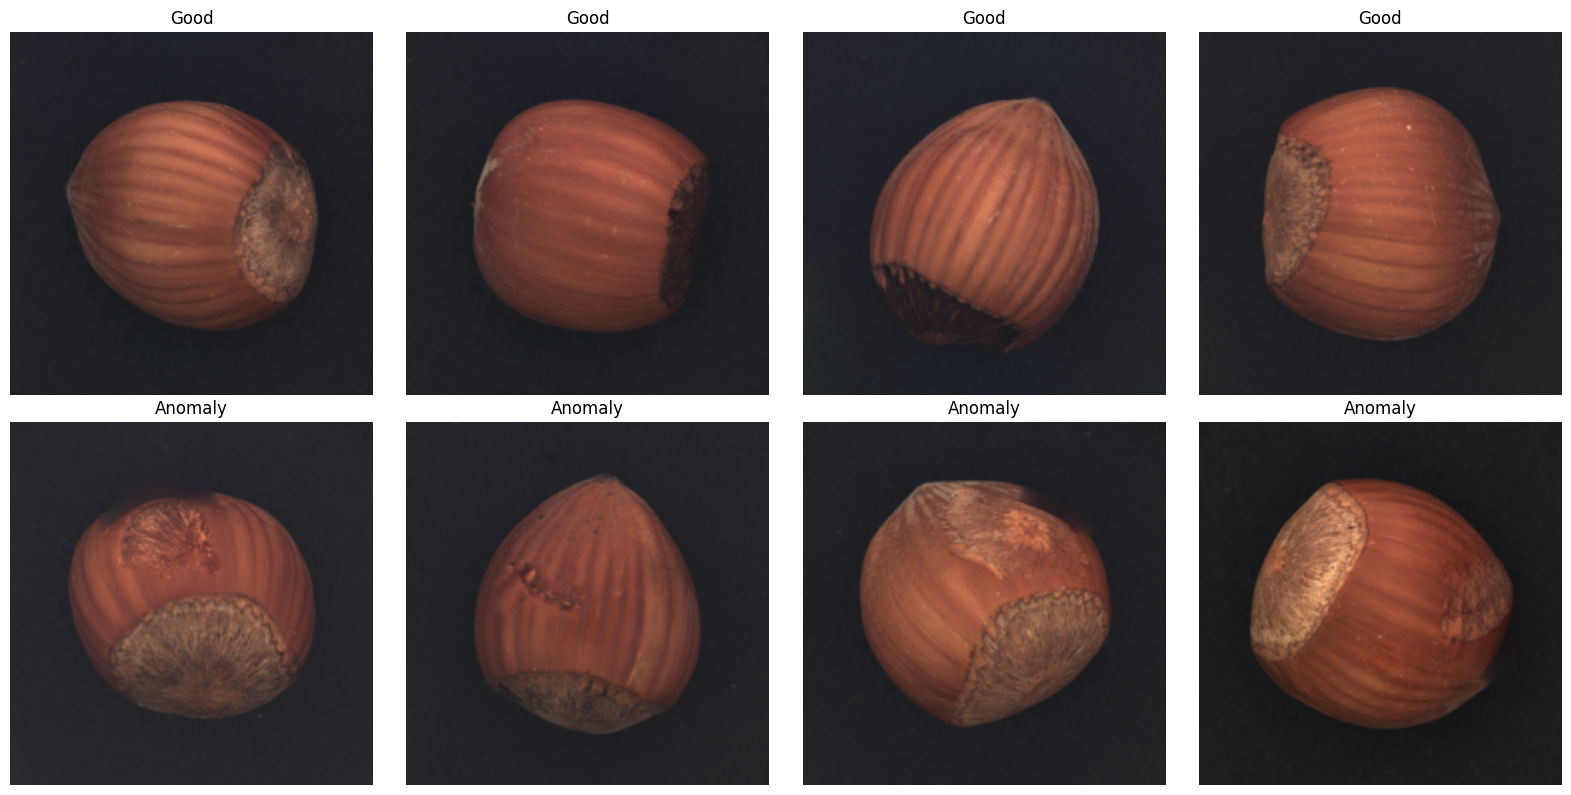

In [97]:
# Visualize some data from the dataset
plt.figure(figsize=(16, 8))
good_count = 0
anomaly_count = 0
max_display = 4
indices = np.random.choice(len(dataset), size=len(dataset), replace=False)
for i in indices:
    image, mask, label = dataset[i]
    print("image.shape ",image.shape)
    print("mask.shape: ", mask.shape)
    print("label: ", label)
    if label == 0 and good_count < max_display:
        plt.subplot(2, 4, good_count + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title('Good')
        plt.axis('off')
        good_count += 1
    elif label == 1 and anomaly_count < max_display:
        plt.subplot(2, 4, 4 + anomaly_count + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title('Anomaly')
        plt.axis('off')
        anomaly_count += 1
    if good_count >= max_display and anomaly_count >= max_display:
        break
plt.tight_layout()
plt.show()

In [98]:
# Shuffle and split the dataset
dataset_size = len(dataset)
train_size = int(0.80 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [99]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [100]:
# Define the model for pixel-level classification and image-level classification
class UNetWithClassification(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, num_classes=2):
        super(UNetWithClassification, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.encoder = nn.Sequential(*self.encoder_layers)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, kernel_size=1)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        segmentation_output = self.decoder(encoded)
        classification_output = self.classifier(encoded)
        return segmentation_output, classification_output

In [105]:
def train_model(model, seg_criterion, class_criterion, optimizer, dataloader, device):
    model.train()
    running_seg_loss = 0.0

    for images, masks, labels in tqdm(dataloader, desc="Training", leave=False):
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        seg_outputs = model(images)
        if isinstance(seg_outputs, tuple):
            seg_outputs = seg_outputs[0]  # Extract the first element if seg_outputs is a tuple
        if seg_outputs.size() != masks.size():
            masks = transforms.Resize(seg_outputs.shape[-2:])(masks)
        seg_loss = seg_criterion(seg_outputs, masks)
        seg_loss.backward()
        optimizer.step()
        running_seg_loss += seg_loss.item() * images.size(0)

    epoch_seg_loss = running_seg_loss / len(dataloader.dataset)
    wandb.log({"Train Segmentation Loss": epoch_seg_loss})
    return epoch_seg_loss

In [106]:
def validate_model(model, seg_criterion, class_criterion, dataloader, device):
    model.eval()
    running_seg_loss = 0.0

    with torch.no_grad():
        for images, masks, labels in tqdm(dataloader, desc="Validation", leave=False):
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            seg_outputs = model(images)
            if isinstance(seg_outputs, tuple):
                seg_outputs = seg_outputs[0]  # Extract the first element if seg_outputs is a tuple
            if seg_outputs.size() != masks.size():
                masks = transforms.Resize(seg_outputs.shape[-2:])(masks)
            seg_loss = seg_criterion(seg_outputs, masks)
            running_seg_loss += seg_loss.item() * images.size(0)

    epoch_seg_loss = running_seg_loss / len(dataloader.dataset)
    wandb.log({"Validation Segmentation Loss": epoch_seg_loss})
    return epoch_seg_loss

In [107]:
# Set device, initialize model, criterion, optimizer, and learning rate scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetWithClassification().to(device)
seg_criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy for segmentation
class_criterion = nn.CrossEntropyLoss()  # Cross-Entropy for classification
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


In [109]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    train_seg_loss = train_model(model, seg_criterion, None, optimizer, train_loader, device)
    val_seg_loss = validate_model(model, seg_criterion, None, val_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Seg Loss: {train_seg_loss:.4f}, Val Seg Loss: {val_seg_loss:.4f}')

    # Update learning rate scheduler
    scheduler.step(val_seg_loss)

    # Save model if validation loss improves
    torch.save(model.state_dict(), f'./best_model_epoch_{epoch+1}.pth')

Epoch [1/10], Train Seg Loss: 0.0937, Val Seg Loss: 0.0377


Epoch [2/10], Train Seg Loss: 0.0248, Val Seg Loss: 0.0349


Epoch [3/10], Train Seg Loss: 0.0167, Val Seg Loss: 0.0248


Epoch [4/10], Train Seg Loss: 0.0143, Val Seg Loss: 0.0228


Epoch [5/10], Train Seg Loss: 0.0132, Val Seg Loss: 0.0291


Epoch [6/10], Train Seg Loss: 0.0119, Val Seg Loss: 0.0267


Epoch [7/10], Train Seg Loss: 0.0113, Val Seg Loss: 0.0284


Epoch [8/10], Train Seg Loss: 0.0114, Val Seg Loss: 0.0307
Epoch 00008: reducing learning rate of group 0 to 5.0000e-05.


Epoch [9/10], Train Seg Loss: 0.0109, Val Seg Loss: 0.0319


Epoch [10/10], Train Seg Loss: 0.0104, Val Seg Loss: 0.0293


In [110]:
# Add the testing part
class HazelnutTestDataset(Dataset):
    """
    Custom dataset for loading test images from 'hazelnut/test' directory.
    Images in 'good' folder are labeled as 'good', while images in 'cut', 'crack', and 'hole' folders are labeled as 'synthetic_anomalous'.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        # Define label names based on folder names
        self.classes = {'good': 0, 'crack': 1, 'cut': 1, 'hole': 1, 'print': 1}

        # Loop through each folder and assign labels accordingly
        for label_name, label in self.classes.items():
            folder_path = os.path.join(root_dir, label_name)
            if os.path.isdir(folder_path):
                for img_file in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_file)
                    self.data.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB to ensure 3 channels
        label = self.labels[idx]
        
        # Apply transformations, if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [113]:
# Initialize the test dataset and data loader
test_dataset = HazelnutTestDataset(root_dir="../datasets/mvtec/hazelnut/test/", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [135]:
# Test the model
model.load_state_dict(torch.load('./best_model_epoch_9.pth'))
model.eval()
total = 0
correct = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing", leave=False):
        images, labels = images.to(device), labels.to(device)
        _, class_outputs = model(images)
        class_outputs = class_outputs.squeeze()

        # Get the predicted class by taking the argmax across the last dimension
        if class_outputs.ndim > 1 and class_outputs.size(1) > 1:
            predicted = torch.argmax(class_outputs, dim=1)
            # print("class_outputs: ", predicted)
        else:
            predicted = (class_outputs > 0.1).long().squeeze()
            # print("else class_outputs: ", predicted)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        
        all_predictions.extend(predicted.cpu().numpy())
    print("all_labels: ", all_labels)
    print("all_predictions: ", all_predictions)

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

all_labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
all_predictions:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Test Accuracy: 63.64%


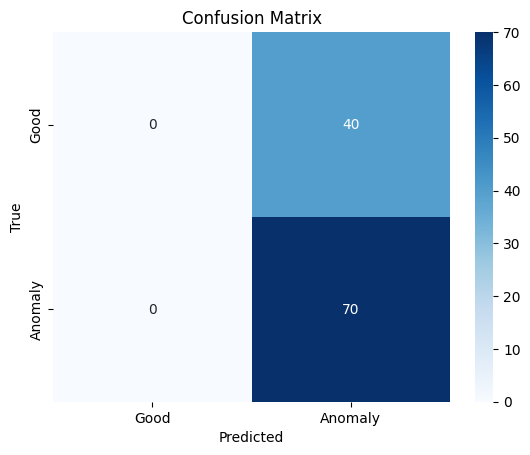

In [133]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Anomaly'], yticklabels=['Good', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()